In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [2]:
#! pip install langgraph-checkpoint-sqlite

In [3]:
# from langgraph.checkpoint.sqlite import SqliteSaver

# memory = SqliteSaver.from_conn_string(":memory:")

In [4]:
# Create the tools
 
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://saksheepatil05.medium.com/demystifying-langgraph-a-beginner-friendly-dive-into-langgraph-concepts-5ffe890ddac0',
  'content': 'Nodes (Tasks): Nodes are like the workstations on the assembly line. Each node performs a specific task on the product. In LangGraph, nodes are Python functions that take the current state, do some work, and return an updated state. Next, we define the nodes, each representing a task in our sandwich-making process.'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state ..."}]

In [5]:
llm_with_tools = llm.bind_tools(tools)


In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [8]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [9]:
graph_builder = StateGraph(State)

In [10]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [11]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools=[tool])

In [12]:
graph_builder.add_node("chatbot", chatbot)


In [13]:
graph_builder.add_node("tools", tool_node)

In [14]:
graph_builder.add_edge(START, "chatbot")

In [15]:
graph_builder.add_edge("tools", "chatbot")

In [16]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [18]:
graph = graph_builder.compile(checkpointer=memory)

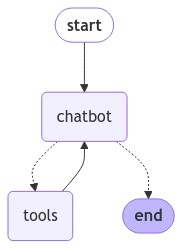

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
# Function to generate a unique thread ID
import uuid

def generate_thread_id() -> str:
    return str(uuid.uuid4())

In [21]:
thread_id_1 = generate_thread_id()

In [22]:
config_1 = {"configurable": {"thread_id": thread_id_1}}

In [23]:
snapshot = graph.get_state(config_1)
snapshot.next

()

In [24]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config_1, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


In [25]:
snapshot = graph.get_state(config_1)


In [27]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', id='2b5b5ad8-ced0-4614-a94b-fda06a535eff'), AIMessage(content='Hello Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 87, 'total_tokens': 98, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'stop', 'logprobs': None}, id='run-5ea81b0a-611d-4bfb-a9ba-7a1f3f854c88-0', usage_metadata={'input_tokens': 87, 'output_tokens': 11, 'total_tokens': 98})]}, next=(), config={'configurable': {'thread_id': 'ebeddaa2-291b-43a2-9a37-0d6761f1e496', 'checkpoint_ns': '', 'checkpoint_id': '1ef7e598-0c95-6fd4-8001-576a43b0fe69'}}, metadata={'source': 'loop', 'writes': {'chatbot': {'messages': [AIMessage(content='Hello Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': 

In [28]:
snapshot.next

()

In [29]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config_1, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name, Will! How can I help you today?


In [30]:
thread_id_2 = generate_thread_id()
config_2 = {"configurable": {"thread_id": thread_id_2}}

In [31]:
user_input = "Remember my name?"
events = graph.stream(
    {"messages": [("user", user_input)]}, config_2, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I'm sorry, but I don't have the ability to remember personal information or previous interactions. How can I assist you today?


In [32]:
user_input = "Remember my name?"
events = graph.stream(
    {"messages": [("user", user_input)]}, config_1, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will! What would you like to talk about today?
